map created
start / end points created
adjacency list created


(<Figure size 288x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x15c6190>)

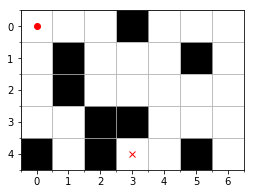

In [12]:
''' 
objective 190811: work on creating a depth-first search and breadth-first search 
    example here, then transferring back to a python script. using jupyter 
    notebook because of it's rapid prototyping capability

objective 190814: work on creating iterative deepening search
objective 190814: work on heuristic search, starting with A*

random maze generator: https://keesiemeijer.github.io/maze-generator/
'''

import numpy as np
import matplotlib.pyplot as plt
import time
import PIL.Image as pil
# setup functions
def plotgrid(gridarr,start,end,fsize=4):
    ''' ensure that plot comes out nicely formatted '''
    nrows,ncols = gridarr.shape    
    f,p=plt.subplots(figsize=[fsize]*2)
    p.imshow(gridarr,cmap='gray')
    xticks=np.arange(0,ncols+1)-0.5
    yticks=np.arange(0,nrows+1)-0.5
    xlims=[xticks.min(),xticks.max()]
    ylims=[yticks.min(),yticks.max()]
    p.set_xticks(xticks,minor=True)
    p.set_yticks(yticks,minor=True)
    p.grid(b=True,which='minor')
    p.plot(*start[::-1],'ro')
    p.plot(*end[::-1],'rx')
    return f,p
def plotans(ax,anspath,ansgrid,color=[0,1,0]):
    w=ansgrid.shape[1]
    coords = np.array(path2coords(anspath,w))
    x=coords[:,1]
    y=coords[:,0]
    ax.plot(x,y,color=color)
def canGoInDir(arr,coord,direction):
    ''' 
    create a map that says whether a point can go in a given direction. 
        alternative to making a tree in the typical sense. 
        only works with orthogonal directions (no diagonals coded here)
    '''
    row,col=coord
    if(direction==0):
        # check if can go 'up'
        if(row==0): return False # at top row
        elif(arr[row-1,col]==0): return False # occupied
        else: return True
    elif(direction==1): 
        # check if can go 'right'
        if(col==arr.shape[1]-1): return False # at right-most column
        elif(arr[row,col+1]==0): return False # occupied
        else: return True
    elif(direction==2): 
        # check if can go 'down'
        if(row==arr.shape[0]-1): return False # at bottom row
        elif(arr[row+1,col]==0): return False # occupied
        else: return True
    elif(direction==3):
        # check if can go 'left'
        if(col==0): return False # at left-most column 
        elif(arr[row,col-1]==0): return False # occupied
        else: return True
    else: print('error: not a valid direction')

def coord2cellnum(coord,gridwidth):
    ''' assume coordinate is (row,col) '''
    return coord[0]*gridwidth+coord[1]
def cellnum2coord(num,gridwidth):
    i=1
    while(i*gridwidth<=num):i+=1
    i-=1
    return [i,num-i*gridwidth]
def makeAdjList(arr):
    ''' create adjacency list '''
    adjList = dict()
    w=arr.shape[1]
    for i,irow in enumerate(arr):
        for j,jcol in enumerate(irow):
            if(arr[i,j]!=0):
                # not empty
                ilist = []
                if(canGoInDir(arr,[i,j],0)): ilist.append((i-1)*w+j) # can go up
                if(canGoInDir(arr,[i,j],1)): ilist.append(i*w+(j+1)) # right
                if(canGoInDir(arr,[i,j],2)): ilist.append((i+1)*w+j) # down
                if(canGoInDir(arr,[i,j],3)): ilist.append(i*w+(j-1)) # left
                cellNo = int(i*arr.shape[1]+j)
                adjList[cellNo] = ilist
    return adjList
def path2coords(pathlist,gridwidth):
    w=gridwidth;coords = []
    for ipoint in pathlist:
        coords.append( cellnum2coord(ipoint,w) )
    return coords

''' create a desired map and generate accompanying adjacency list '''

# grid 4 (dungeon problem grid)
grid = np.ones((5,7))
grid[0,3]=0
grid[1,1]=0
grid[1,5]=0
grid[2,1]=0
grid[3,2]=0
grid[3,3]=0
grid[4,0]=0
grid[4,2]=0
grid[4,5]=0
loc_start=[0,0]
loc_end  =[4,3] # row/col format

print('map created')

w=grid.shape[1]
st = coord2cellnum(loc_start,w)
en = coord2cellnum(loc_end,w)
print('start / end points created')

adj=makeAdjList(grid)
print('adjacency list created')
plotgrid(grid,loc_start,loc_end)

In [2]:
''' bfs implementation '''
# version1: just see if you can find a solution

def bfs(_adjlist,options,goal,history=None,oldoptions=None):
    ''' simple attempt at bfs. added "history" to properly keep track of where things have been 
    INPUTS: 
        * _adjlist: adjacency list. essentially a list of new available paths
        * options: starting location. internally, list of current options
        * goal: end point to reach.
    '''
    if(type(options)!=list):
        # first iteration
        history=[options] # prevent infinite loops
        options=[options] # aka current location
    else:
        history+=options
    newoptions=[]
    prevoptions=[]
    for i,ioption in enumerate(options): # for each currently known option...
        if(ioption==goal):
            return [ioption] # return solution
        # while generating new paths, remember old ones
        for inew in _adjlist[ioption]:
            if(inew not in history):
                newoptions.append(inew)
                prevoptions.append(ioption)
    if(len(newoptions)>0):
        # can continue
        path = bfs(_adjlist,newoptions,goal,history.copy(),prevoptions.copy())
        if(type(path)==list):
            # if a solution is found, path represents correct item in newoptions
            # finding the index of that option leads to the right previous option
            iloc=newoptions.index(path[0])
            path.insert(0,prevoptions[iloc])
            return path
    else:
        return None


In [3]:
''' demonstrate two examples: a pass and a fail '''
print('fail test:',bfs(adj,st,3))
print('--------')
print('success:',bfs(adj,st,en))

fail test: None
--------
success: [0, 1, 2, 9, 10, 11, 18, 25, 32, 31]


In [4]:
''' dfs implementation '''

def dfs(_adjlist,curr,goal,path=None,iter1=True):
    ''' second attempt at more elegant dfs. remember: key is backtracking '''
    if(type(path)==type(None)):
        # first iteration
        path=[]
    path.append(curr)
    if(curr == goal):
        return path
    res=None
    for ioption in _adjlist[curr]:
        if(ioption not in path):
            # haven't explored this location yet
            res = dfs(_adjlist,ioption,goal,path.copy(),iter1=False)
            if(res!=None):
                # have found something
                return res
    if(iter1):
        return None

fail: None
--------
good: [0, 1, 2, 9, 10, 11, 4, 5, 6, 13, 20, 27, 26, 19, 18, 25, 32, 31]
[0, 1, 2, 9, 10, 11, 4, 5, 6, 13, 20, 27, 26, 19, 18, 25, 32, 31]
mms: 2228.4984588623047


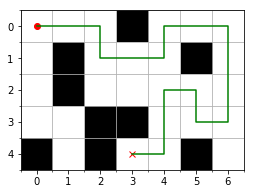

In [5]:
print('fail:',dfs(adj,st,3))
print('--------')
print('good:',dfs(adj,st,en))
# SUCCESS!!!

t0=time.time()
path = dfs(adj,st,31)
print(path)
print('mms:',(time.time()-t0)*1000000)

coords=np.array(path2coords(path,grid.shape[1]))
x=coords[:,1]
y=coords[:,0]
f,p=plotgrid(grid,loc_start,loc_end)

p.plot(x,y,'g-')

fail (no find): -1
--------
good: [0, 1, 2, 9, 10, 11, 18, 25, 32, 31]
[0, 1, 2, 9, 10, 11, 18, 25, 32, 31]


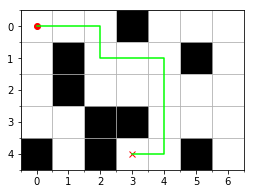

In [6]:
''' at this point, wanna start iterative deepening 
1. 
'''
def dfsB(_adjlist,curr,goal,depthlim=20,path=None,iter1=True,depthcount=0):
    ''' second attempt at more elegant dfs. remember: key is backtracking '''
    if(type(path)==type(None)):
        # first iteration
        path=[]
    path.append(curr)
    if(curr == goal):
        return path
    res=None
    flag_dplim=False
    if(depthcount>=depthlim):
        return -2 # need to define different failure modes
    for ioption in _adjlist[curr]:
        if(ioption not in path):
            # haven't explored this location yet
            res = dfsB(_adjlist,ioption,goal,depthlim,path.copy(),False,depthcount+1)
            if(res==-2):
                flag_dplim=True
            elif(res!=None):
                # have found something, not hit depth limit
                return res
    if(flag_dplim==True):
        return -2 # want to be able to know if failed because hit depth limit
    if(iter1):
        return -1 # defining different failure modes

def ids(adjlist,curr,goal):
    ''' iterative deepening '''
    dplim = 0
    maxdp=4000
    res=-2
    done = False
    while(not done and dplim<maxdp):
        res = dfsB(adjlist,curr,goal,dplim)
        if(res==-1):
            return -1
        elif(type(res)==list):
            return res
        dplim+=1
    return -1

print('fail (no find):',ids(adj,st,3))
print('--------')
sol = ids(adj,st,en)
print('good:',sol)
print(sol)
# SUCCESS!!!

f,p=plotgrid(grid,loc_start,loc_end)
plotans(p,sol,grid)


solved, len: 109
alt soln, len: 137


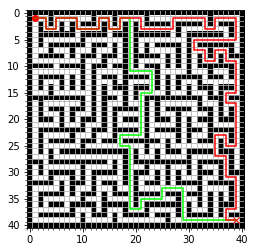

In [7]:
maze=np.array(pil.open('maze4.png').convert('L'))
st_loc = [1,1]
en_loc = np.array(maze.shape)-2
f,p=plotgrid(maze,st_loc,en_loc)

st1 = coord2cellnum(st_loc,maze.shape[1])
en1 = coord2cellnum(en_loc,maze.shape[1])
adj1=makeAdjList(maze)
exit
# # attempt 1
# sol = dfs(adj1,st1,en1)
# print(sol)
# plotans(p,sol,maze)
# attempt 2
sol = ids(adj1,st1,en1)
if(type(sol)==list):
    print('solved, len:',len(sol))
    plotans(p,sol,maze)
sol2= dfs(adj1,st1,en1)
if(type(sol2)==list):
    print('alt soln, len:',len(sol2))
    plotans(p,sol2,maze,color='red')

so, at this point, have developed bfs, dfs, and iterative deepening search (ids). next comes heuristic search, starting with A*

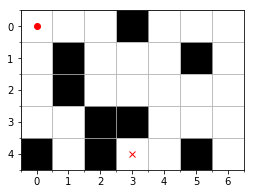

In [8]:
''' will try to work on heuristic search 

main thing to keep in mind: heuristics are all about finding a 
    good solution *fast*. it's not about finding the best solution necessarily, 
    but instead finding a reasonable one in a short amount of time. This is
    important for real-time applications.

will go straight to calculating costs and greedy search, then moving 
    into A* search

in this first example, will need to augment "makeAdjList" with heuristic values. 
    will use norm2 distance to target, aka "pythagorean distance".

for the new function, need goal. for each cell, provide the norm2 distance to 
    the goal
KJG190816: won't need to worry about creating a distance to each new node, since 
    each movement on the grid is 1 unit. thus, this may be omitted.
KJG190816: norm2 dist is always "<=" than actual distance, so is called "admissible"
KJG190816: heuristic eval will be: 
    f(s) = g(s) + h(s), where:
        g(s): sum of costs to current node
        h(s): heuristic distance to goal from current node
        
KJG190816: probably can't use recursion anymore... will need to keep a running list 
    of stuff, and switch to a new path when the current path becomes too expensive.
'''

def pyt(p1,p2):
    ''' p1,p2: [x,y] locations '''
    return ((p2[0]-p1[0])**2+(p2[1]-p1[1])**2)**0.5

def makeAdjListHerustics(arr,goal):
    ''' create adjacency list 
    INPUTS: 
        * arr: 2D grid or maze to use
        * goal: (x,y) coordinate of desired end goal
    OUTPUT:
        * dict: cellnum: [[nextcell0,dist0],[nextcell1,dist1],...]
    '''
    # will not control for choosing unreachable location, goal can be wherever
    _adjList = dict()
    w=arr.shape[1]
    for i,irow in enumerate(arr):
        for j,jcol in enumerate(irow):
            if(arr[i,j]!=0):
                # not empty
                ilist = []
                if(canGoInDir(arr,[i,j],0)): # can go up
                    cellnum=(i-1)*w+j # future cell location
                    d=pyt(goal,[i-1,j])
                    ilist.append([cellnum,d]) 
                if(canGoInDir(arr,[i,j],1)): # right
                    cellnum=i*w+(j+1)
                    d=pyt(goal,[i,j+1])
                    ilist.append([cellnum,d]) 
                if(canGoInDir(arr,[i,j],2)): # down
                    cellnum=(i+1)*w+j
                    d=pyt(goal,[i+1,j])
                    ilist.append([cellnum,d]) 
                if(canGoInDir(arr,[i,j],3)): # left
                    cellnum=i*w+(j-1)
                    d=pyt(goal,[i,j-1])
                    ilist.append([cellnum,d])
                cellNo = int(i*arr.shape[1]+j)
                _adjList[cellNo] = ilist
    return _adjList



f,p=plotgrid(grid,loc_start,loc_end)
adj= makeAdjListHerustics(grid,loc_end)


In [49]:
''' perhaps try defining "heuristic search", then working towards A* '''

def grabfrom(listvar):
    ''' assuming that some list is ordered correctly, 
    return the first item and return list without that item 
    KJG190819: may not be necessary, perhaps remove in future
    '''
    return listvar[0],listvar[1:]

def sortin_dfs(oldnodes,newnodes,parent,history_nodes,oldpaths,hist2):
    ''' sort in values based on simply putting the first option at the start of the list '''
    # part 1: add in new nodes for dfs
    nodelist = []
    pathlist = []
    for inew in newnodes:
        if(inew not in history_nodes):
            nodelist+=[inew]
            ipath=oldpaths[0]+[parent]
            pathlist.append(ipath)
            hist2[inew]=parent
    # part 2: add in old nodes for dfs
    nodelist+=oldnodes
    pathlist+=oldpaths[1:]
    return nodelist,pathlist,hist2

def heuristic(adjlist,start,goal):
    ''' general "heuristic search", following book '''
    nodelist=[start] # initialize
    hist=[]
    hist2=dict()
    paths=[[]]
    i=0
    maxit=10000
    inode=None
    flag_search = True
    while(flag_search):
        if(len(nodelist)==0):
            print('no solution found')
            return None
        print(inode,nodelist,len(paths))
        inode, nodelist = grabfrom(nodelist)
        hist.append(inode)
        if(inode==goal):
            print('solved!')
            print(paths[0]+[goal])
            print(hist2)
            return goal
        nodelist,paths,hist2 = sortin_dfs(nodelist,adjlist[inode],inode,hist,paths,hist2)
        i+=1
        # import ipdb;ipdb.set_trace()
        if(i>=maxit):
            print('max iterations reached')
            flag_search=False
            return None
heuristic(adj,st,10)

None [0] 1
0 [1, 7] 2
1 [2, 7] 2
2 [9, 7] 2
9 [10, 16, 7] 3
solved!
[0, 1, 2, 9, 10]
{1: 0, 7: 0, 2: 1, 9: 2, 10: 9, 16: 9}


10

In [50]:
d={1: 0, 7: 0, 2: 1, 9: 2, 10: 9, 16: 9}

In [59]:
a=0
b=10
loc=b
order=[loc]
while(loc!=a):
    loc=d[loc]
    order.insert(0,loc)
    
print(order)

[0, 1, 2, 9, 10]


In [64]:
2 in [d[ikey] for ikey in d.keys()]

True

NEED TO CAPITALIZE ON THIS! MAY BE ABLE TO USE DICTIONARY AS A PSEUDO-LINKED LIST IN ORDER TO BOTH KEEP TRACK OF HISTORY AND PATH SOLUTION